In [2]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import json
path = Path('../save_data/Classificator_data/')
if not path.exists():
    print("No data found in the specified path.")

In [10]:
import re

jsons = sorted(
    path.glob('*.json'),
    key=lambda f: int(re.search(r'v(\d+)', f.name).group(1))
)

print(f'Found {len(jsons)} JSON files in {path}')

histories = []
for json_file in jsons:
    print(f'Reading {json_file}')
    with open(json_file, 'r') as file:
        histories.append(file.read())


Found 15 JSON files in ../save_data/Classificator_data
Reading ../save_data/Classificator_data/history_v1.json
Reading ../save_data/Classificator_data/history_v2.json
Reading ../save_data/Classificator_data/history_v3.json
Reading ../save_data/Classificator_data/history_v4.json
Reading ../save_data/Classificator_data/history_v5.json
Reading ../save_data/Classificator_data/history_v6.json
Reading ../save_data/Classificator_data/history_v7.json
Reading ../save_data/Classificator_data/history_v9.json
Reading ../save_data/Classificator_data/history_v10.json
Reading ../save_data/Classificator_data/history_v11.json
Reading ../save_data/Classificator_data/history_v12.json
Reading ../save_data/Classificator_data/history_v13.json
Reading ../save_data/Classificator_data/history_v14.json
Reading ../save_data/Classificator_data/history_v15.json
Reading ../save_data/Classificator_data/history_v16.json


In [ ]:
for i, history_str in enumerate(histories):
    if i < 8:
        continue
    history = json.loads(history_str)  
    print(f"Training loss: {history['loss']}")
    print(f"Validation Loss: {history['val_loss']}")
    print(f"Validation Accuracy: {history['val_acc']}")
    plt.figure(figsize=(12, 4))
    
    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Train Loss (Run {i + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot validation loss
    plt.subplot(1, 3, 2)
    plt.plot(history['val_loss'], label='Val Loss', color='orange')
    plt.title(f'Validation Loss (Run {i + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot validation accuracy
    plt.subplot(1, 3, 3)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title(f'Validation Accuracy (Run {i + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Show the plots for this run
    plt.tight_layout()
    plt.show()

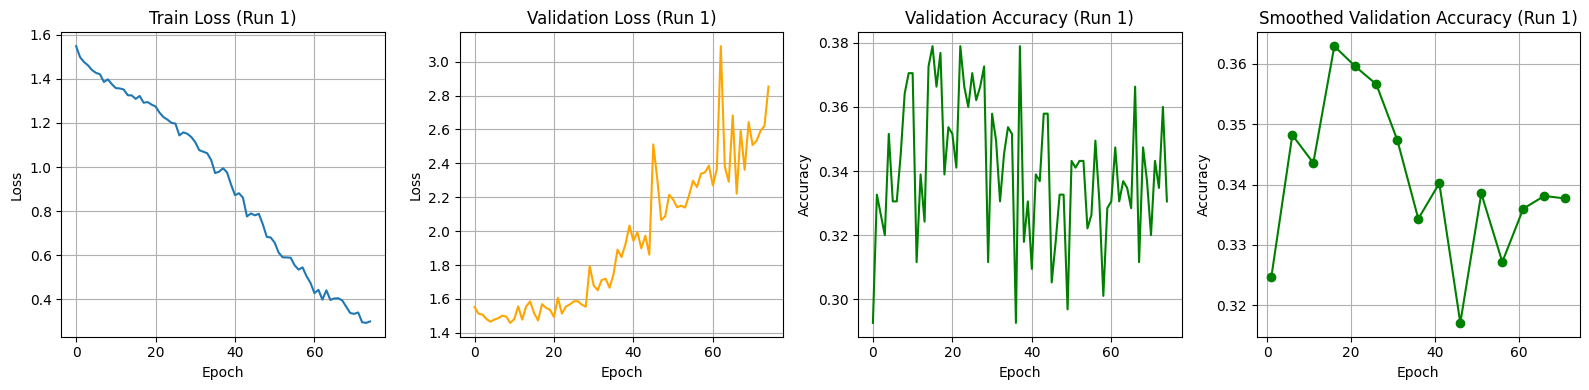

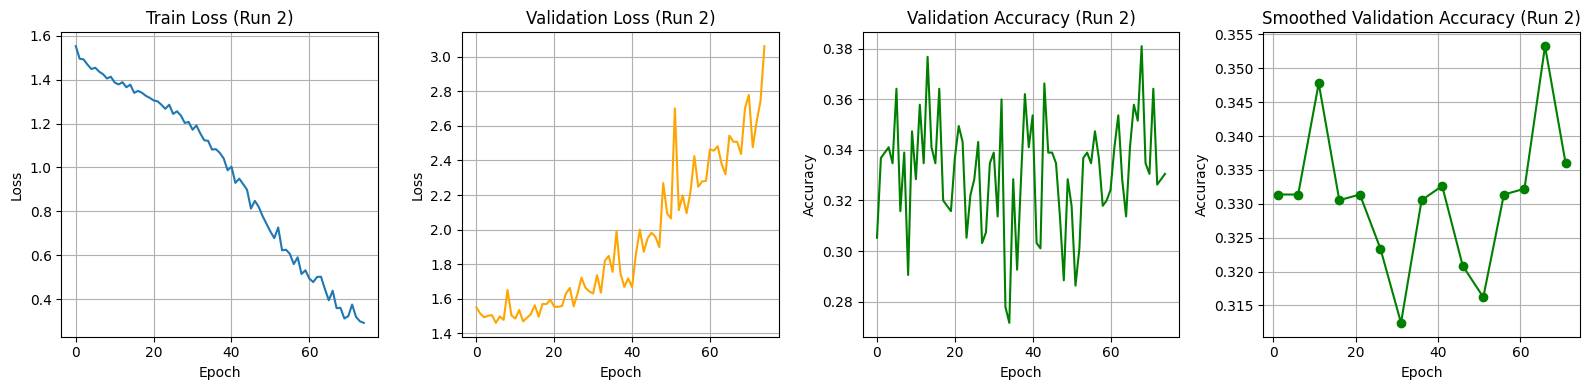

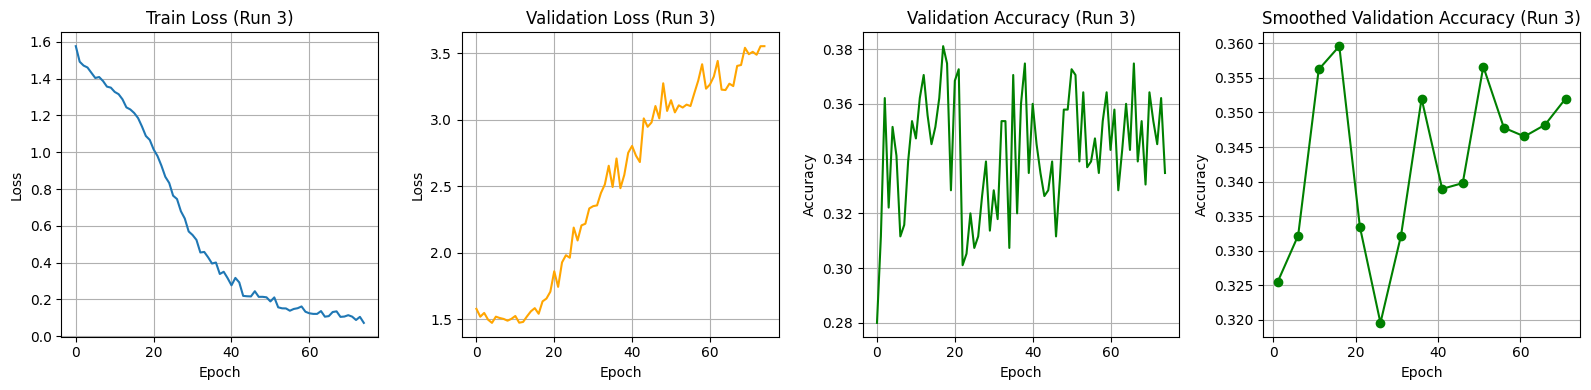

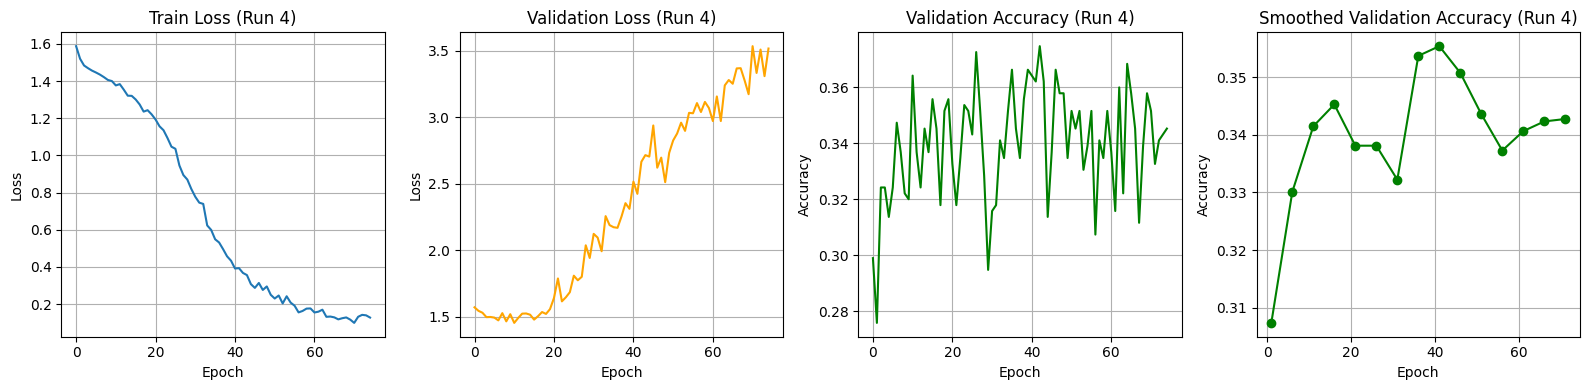

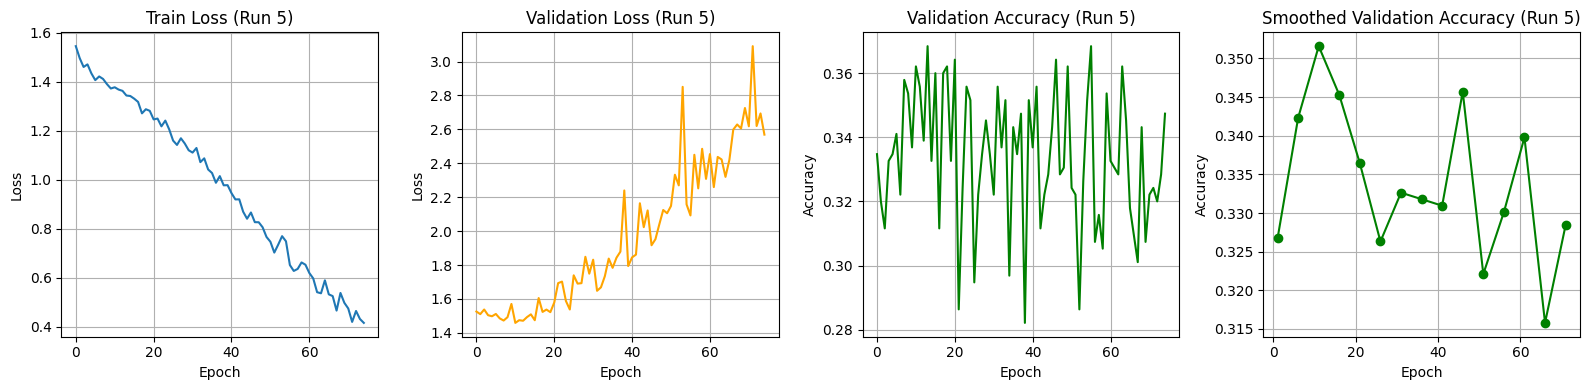

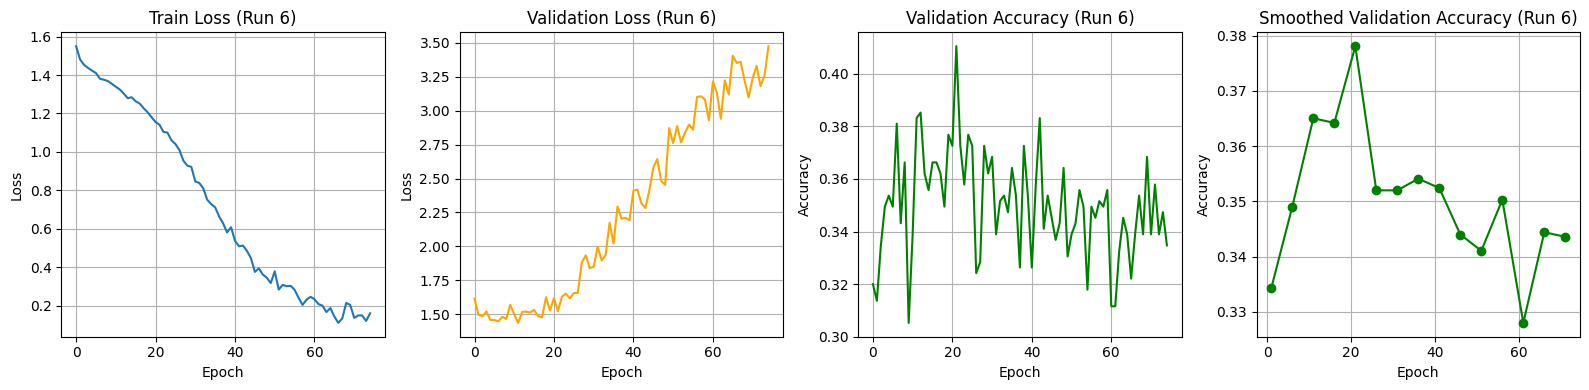

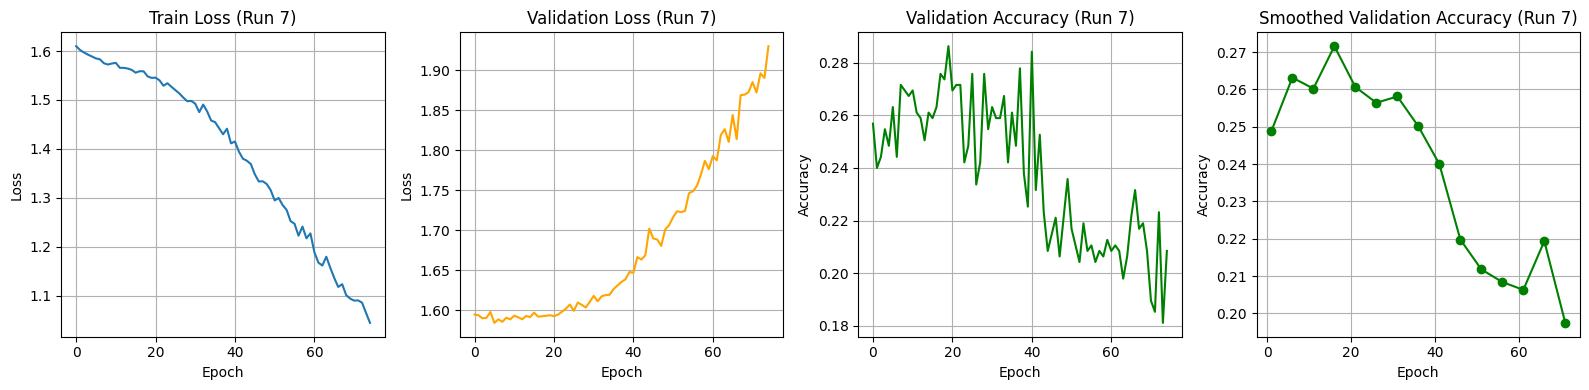

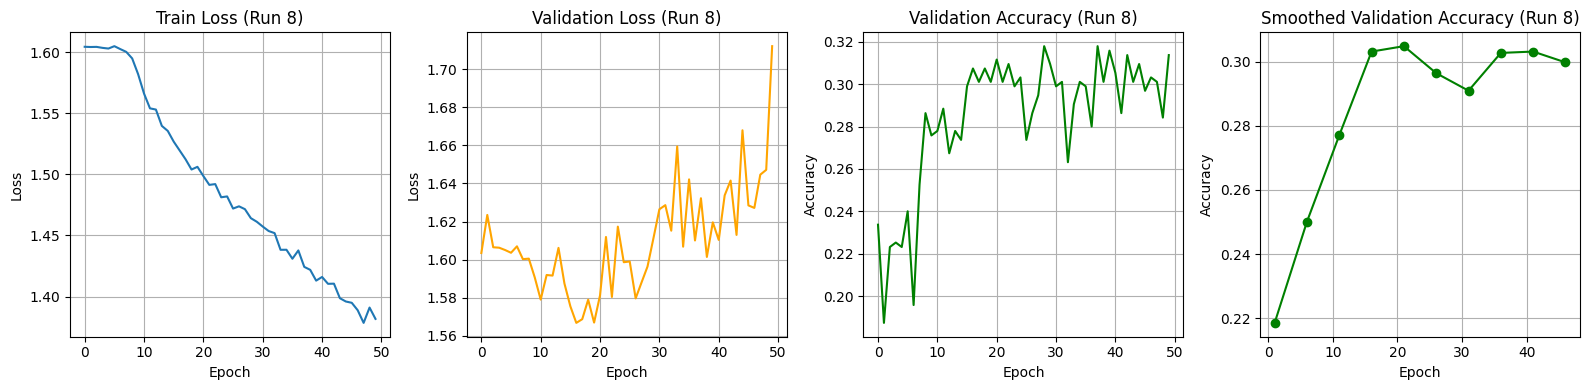

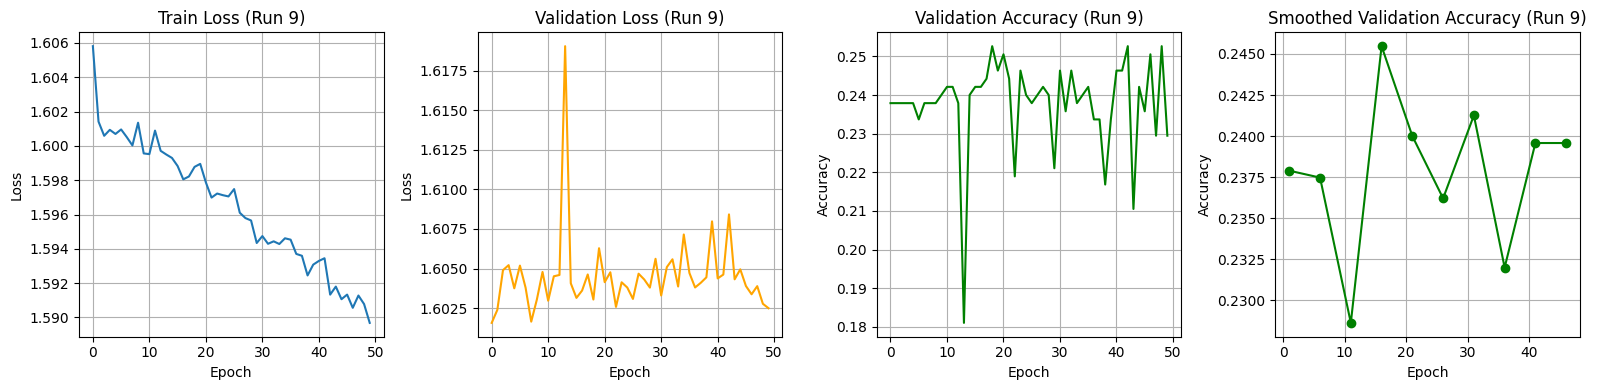

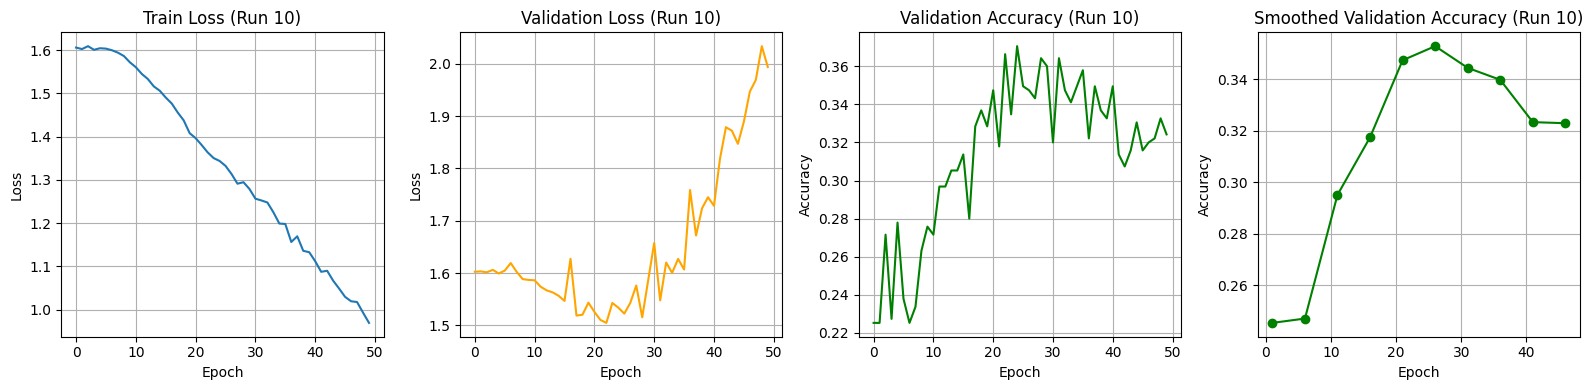

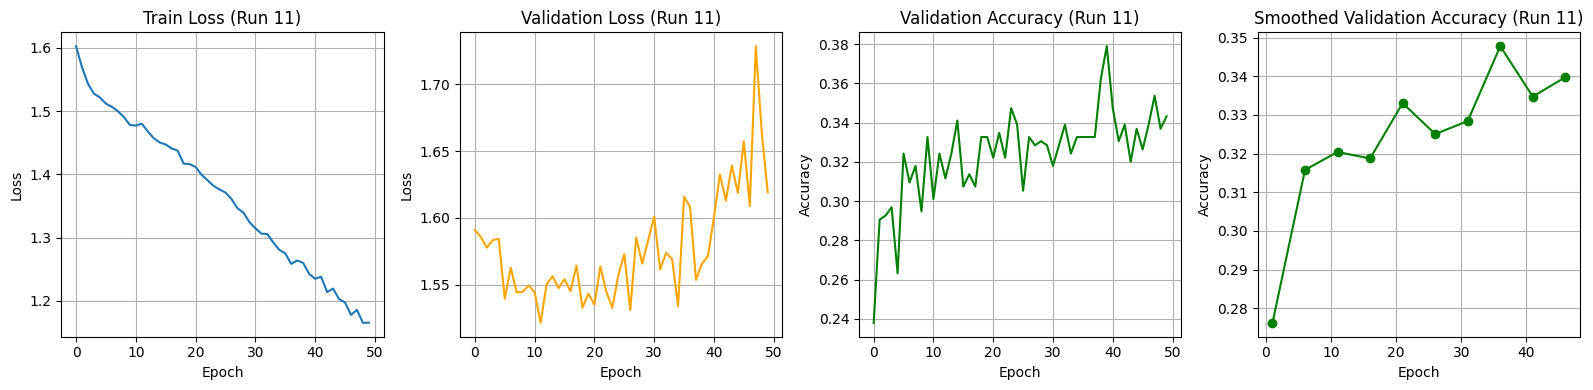

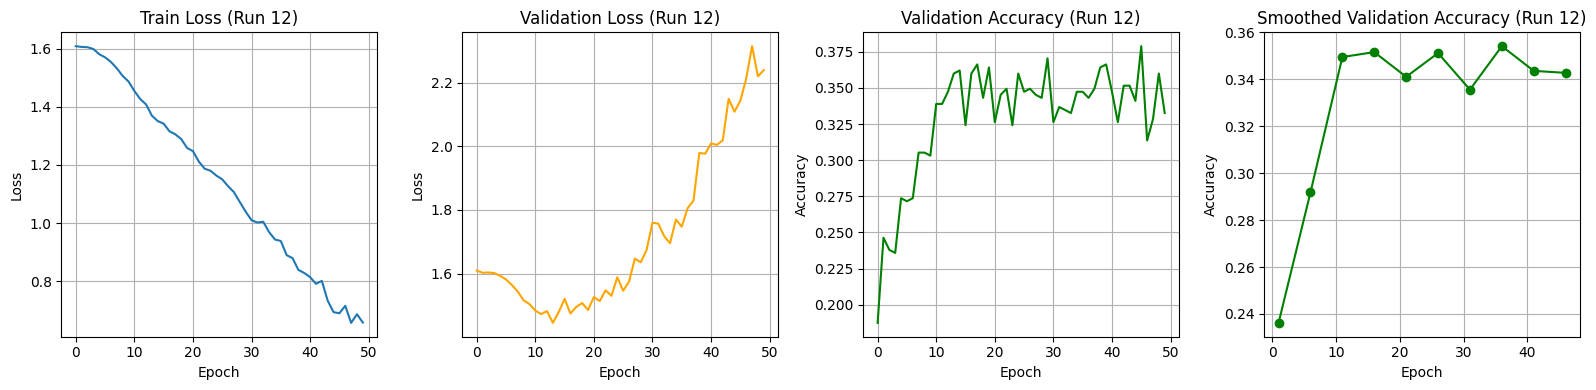

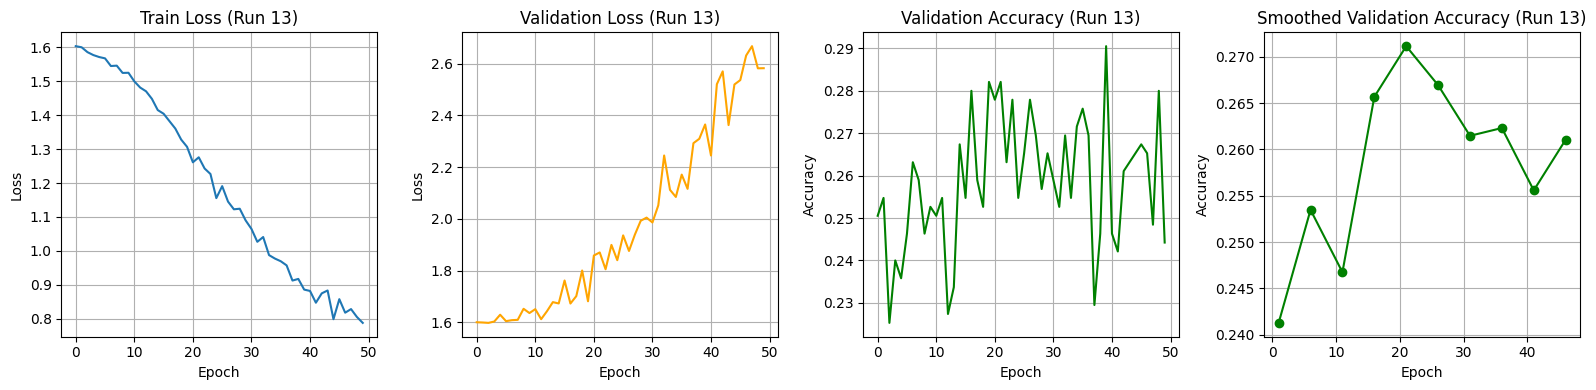

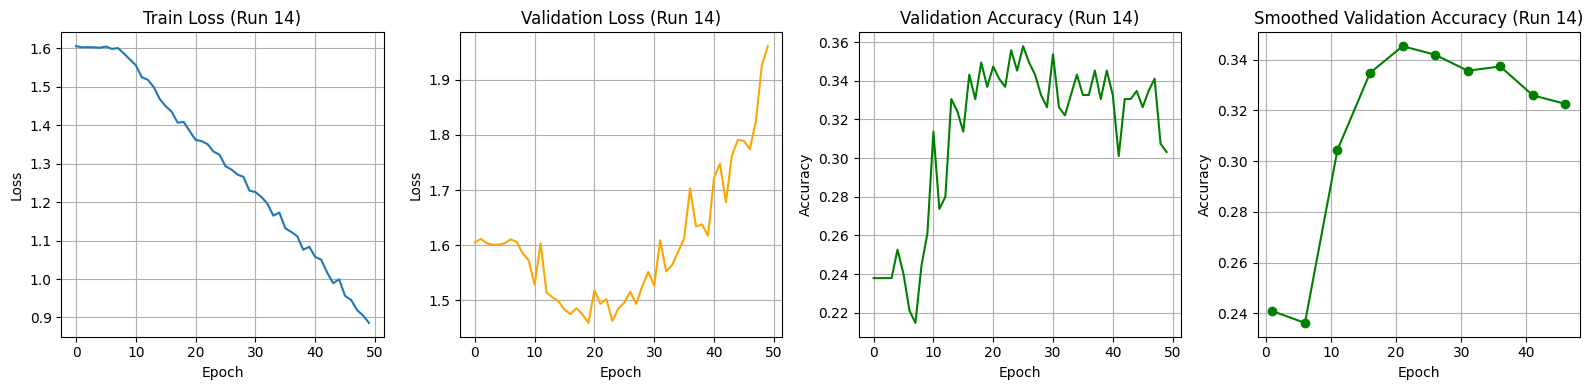

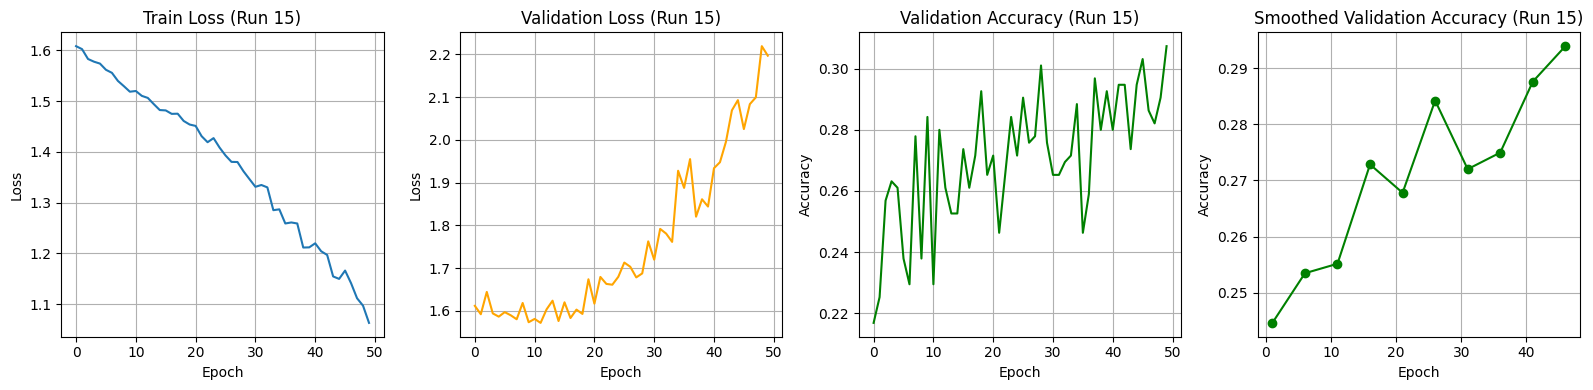

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Grouped average function
def grouped_average(values, group_size):
    return [np.mean(values[i:i + group_size]) for i in range(0, len(values), group_size)]

group_size = 5  # average over 5 epochs

for i, history_str in enumerate(histories):
    #if i < 8:
    #    print(f"Skipping {i} for visualization.")
    #    continue
    history = json.loads(history_str)
    
    val_acc = history['val_acc']
    val_acc_grouped = grouped_average(val_acc, group_size)
    val_acc_epochs = [i + 1 for i in range(0, len(val_acc), group_size)]

    plt.figure(figsize=(16, 4))

    # Loss
    plt.subplot(1, 4, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Train Loss (Run {i + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.ylim(0, 1.0)

    # Val loss
    plt.subplot(1, 4, 2)
    plt.plot(history['val_loss'], label='Val Loss', color='orange')
    plt.title(f'Validation Loss (Run {i + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.ylim(0, 1.0)

    plt.subplot(1, 4, 3)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title(f'Validation Accuracy (Run {i + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0, 1.0)

    # Smoothed val accuracy
    plt.subplot(1, 4, 4)
    plt.plot(val_acc_epochs, val_acc_grouped, label='Val Acc (Avg/5)', color='green', marker='o')
    plt.title(f'Smoothed Validation Accuracy (Run {i + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()


In [ ]:
for i, history_str in enumerate(histories):
    history = json.loads(history_str)  
    print(f"Training loss: {history['loss']}")
    print(f"Validation Accuracy: {history['val_acc']}")
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Train Loss (Run {i + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title(f'Validation Accuracy (Run {i + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Show the plots for this run
    plt.tight_layout()
    plt.show()